In [1]:
import matplotlib.pyplot as plt
import numpy as np
import casperfpga
import time
from lwa_f import snap2_fengine
from lwa_f import blocks
#from lwautils import lwa_arx 
import pandas as pd
from cr_functions import *
import struct
import math
from scipy import special as sp
from scipy import optimize as oz
from scipy import stats as st
from lwa_antpos import mapping
import os



dsautils.cnf not found. skipping...
Read antpos from etcd


## Connect to SNAP2 boards

In [2]:
brdnames=['snap01','snap02','snap03','snap04','snap05','snap06','snap07','snap08','snap09','snap10','snap11']

#connect through Jack's fengine etcd interface for everything that can go through etcd
snapbrds = [snap2_fengine.Snap2FengineEtcd(brdname).fpga for brdname in brdnames]  
fpgfile='/home/ubuntu/kp/caltech-lwa/snap2_f_200msps_64i_4096c/outputs/snap2_f_200msps_64i_4096c.fpg'


2024-02-26 20:37:39,575 - lwa_f.blocks.block:snap01 - INFO - eth - Couldn't find Ethernet core. Will retry later
2024-02-26 20:37:39,580 - lwa_f.blocks.block:snap02 - INFO - eth - Couldn't find Ethernet core. Will retry later
2024-02-26 20:37:39,585 - lwa_f.blocks.block:snap03 - INFO - eth - Couldn't find Ethernet core. Will retry later
2024-02-26 20:37:39,590 - lwa_f.blocks.block:snap04 - INFO - eth - Couldn't find Ethernet core. Will retry later
2024-02-26 20:37:39,595 - lwa_f.blocks.block:snap05 - INFO - eth - Couldn't find Ethernet core. Will retry later
2024-02-26 20:37:39,621 - lwa_f.blocks.block:snap06 - INFO - eth - Couldn't find Ethernet core. Will retry later
2024-02-26 20:37:39,625 - lwa_f.blocks.block:snap07 - INFO - eth - Couldn't find Ethernet core. Will retry later
2024-02-26 20:37:39,630 - lwa_f.blocks.block:snap08 - INFO - eth - Couldn't find Ethernet core. Will retry later
2024-02-26 20:37:39,635 - lwa_f.blocks.block:snap09 - INFO - eth - Couldn't find Ethernet core. 

## Completely reset trigger on all boards to make sure there aren't already trigger and veto settings

In [3]:


veto_roles_array=np.zeros(64,dtype=int)
core_roles_array=np.zeros(64,dtype=int)
for p in range(11):
    snapbrd=snapbrds[p]
    setup_coincidencer(snapbrd,0,
                          0,
                          0,
                          0,
                          0,
                          0,
                          core_roles_array,
                          veto_roles_array)
    setvalue(snapbrd,"enable_coinc_trig","cr_registers.xlsx",0)


## Set up ethernet and send a test snapshot
Ethernet setup doesn't go through etcd yet.

In [ ]:
#connect to the SNAP2s with casperfpga since some functions (ethernet setup) doesn't go through etcd yet
casperbrds = [casperfpga.CasperFpga(brdname, transport=casperfpga.TapcpTransport) for brdname in brdnames]


In [19]:
computer='gpu09' # 'lwacr' or 'gpu09'
packetwait=100 #clock cycles between packets
wait_after_readout=200 #time [clock cycles] to wait for other boards to finish readout
for i,brdname in enumerate(brdnames):
    casperbrd=casperbrds[i]
    #prepare to send a snapshot
    
    setup_data_source(casperbrd,"adc") #set the data source to ADC
    setup_ethernet(brdname,casperbrd,fpgfile,computer,packetwait) #set up the ethernet packetizer and ethernet block
    setvalue(casperbrd,'wait_after_readout','cr_registers.xlsx',wait_after_readout) #set the wait time after readout before new internally-generated triggers are accepted
    setvalue(casperbrd,'brd_id','cr_registers.xlsx',int(brdname[-2:])) #set the board id
    setvalue(casperbrd,'eth_enable','cr_registers.xlsx',1)  #enable ethernet

Data source set to adc
------------------------
snap01:cosmic_ray_cr_forty_gbe configuration:
MAC:  02:02:02:01:01:01
Gateway:  0.0.0.1
IP:  10.41.0.201
Fabric port: 
11111
Fabric interface is currently: Enabled
	base_ip: 255.255.255.255
	ip_mask: 255.255.255.255
	rx_ips: []
ARP Table: 
IP: 10.41.0. 25: MAC: 04:3F:72:DF:C1:F0
Setting wait between packets to 100
Data source set to adc
------------------------
snap02:cosmic_ray_cr_forty_gbe configuration:
MAC:  02:02:02:02:02:02
Gateway:  0.0.0.1
IP:  10.41.0.202
Fabric port: 
11111
Fabric interface is currently: Enabled
	base_ip: 255.255.255.255
	ip_mask: 255.255.255.255
	rx_ips: []
ARP Table: 
IP: 10.41.0. 25: MAC: 04:3F:72:DF:C1:F0
Setting wait between packets to 100
Data source set to adc
------------------------
snap03:cosmic_ray_cr_forty_gbe configuration:
MAC:  02:02:02:03:03:03
Gateway:  0.0.0.1
IP:  10.41.0.203
Fabric port: 
11111
Fabric interface is currently: Enabled
	base_ip: 255.255.255.255
	ip_mask: 255.255.255.255
	rx_ips:

In [5]:
[setvalue(snapbrd,"enable_coinc_trig","cr_registers.xlsx",0) for snapbrd in snapbrds]

#send trigger to just one board and all will send packets
software_trigger(snapbrds[3],1)

Packetizer formed 64 packets
Board successfully returned to listening state after readout
Readout took 137669 clock cycles
Packetizer never overflowed
Ethernet block almost-full counter incremented by 0


## Run Trigger 

In [7]:
[setvalue(snapbrd,"enable_coinc_trig","cr_registers.xlsx",0) for snapbrd in snapbrds]


current_ok_vetos=np.load('/home/ubuntu/kp/ok_vetos-2024-2-21.npy')
current_ok_core=np.load('/home/ubuntu/kp/ok_core-2024-2-21.npy')
ok_snaps=[2,3,4,5,6,7,8,9,10] #zero indexed
#set up coincidencer
trigger_power_thresh=200**2
veto_power_thresh=200**2
trigger_window=int(round(1.96e8*100/3e8,1)) #number of clock cycles to travel 100 meters
veto_window=int(round(1.96e8*2000/3e8,1)) #number of clock cycles to travel 2000 meters
antenna_number_thresh=7
veto_number_thresh=3

bufferwait=2000

for b in ok_snaps:
    snapbrd=snapbrds[b]
    veto_roles_array=current_ok_vetos[b,:]
    core_roles_array=current_ok_core[b,:]

    
    setup_coincidencer(snapbrd,trigger_power_thresh,
                          veto_power_thresh,
                          trigger_window,
                          veto_window,
                          antenna_number_thresh,
                          veto_number_thresh,
                          core_roles_array,
                          veto_roles_array)
    setvalue(snapbrd,"delay_trigger","cr_registers.xlsx",bufferwait)
    setvalue(snapbrd,"enable_coinc_trig","cr_registers.xlsx",1)


## Run Rate Monitor

In [8]:
%%capture output


now=time.time()
duration=30*60 #in seconds
finish=now+duration
waittime=1

core_triggers=np.zeros((11,int(duration/waittime)))
veto_triggers=np.zeros((11,int(duration/waittime)))
core_cycles=np.zeros((11,int(duration/waittime)))
veto_cycles=np.zeros((11,int(duration/waittime)))
successful_triggers=np.zeros((11,int(duration/waittime)))
readout_dones=np.zeros((11,int(duration/waittime)))


i=0

time.sleep(waittime)
while time.time()<finish:
    for b in ok_snaps:
        snapbrd=snapbrds[b]
        veto_coincidence,core_coincidence=struct.unpack('>2l',snapbrd.read("cosmic_ray_core_and_veto_rate",2*4,0))
        veto_total_cycles,core_total_cycles=struct.unpack('>2l',snapbrd.read("cosmic_ray_core_n_veto_tot_clk_cycles",2*4,0))
        readout_done,successful_trigger=struct.unpack('>2l',snapbrd.read("cosmic_ray_core_n_veto_tot_clk_cycles1",2*4,0))
        core_triggers[b,i]=core_coincidence            
        veto_triggers[b,i]=veto_coincidence
        core_cycles[b,i]=core_total_cycles
        veto_cycles[b,i]=veto_total_cycles
        successful_triggers[b,i]=successful_trigger
        readout_dones[b,i]=readout_done
    time.sleep(waittime)
    i+=1
                                                                             
                                                                             


[setvalue(snapbrd,"enable_coinc_trig","cr_registers.xlsx",0) for snapbrd in snapbrds]


Command status from FID 3 returned: 'error'
Command status from FID 3 returned: 'error'
Command status from FID 3 returned: 'error'
Command status from FID 3 returned: 'error'
Command status from FID 3 returned: 'error'
Command status from FID 3 returned: 'error'
Command status from FID 3 returned: 'error'
Command status from FID 3 returned: 'error'
Command status from FID 3 returned: 'error'
Command status from FID 3 returned: 'error'
Command status from FID 3 returned: 'error'


TypeError: a bytes-like object is required, not 'dict'

In [66]:
output.show()

[None, None, None, None, None, None, None, None, None, None, None]

In [67]:
[setvalue(snapbrd,"enable_coinc_trig","cr_registers.xlsx",0) for snapbrd in snapbrds]

[None, None, None, None, None, None, None, None, None, None, None]

In [68]:
fname_prefix='/home/ubuntu/kp/data/2024February21/February21rates'
#np.save(fname_prefix+'core',np.asarray(core_triggers))
#np.save(fname_prefix+'veto',np.asarray(veto_triggers))
#np.save(fname_prefix+'vetocycles',np.asarray(veto_cycles))
#np.save(fname_prefix+'corecycles',np.asarray(core_cycles))
#np.save(fname_prefix+'successfultrigger',np.asarray(successful_triggers))
#np.save(fname_prefix+'readoutdone',np.asarray(readout_dones))


In [69]:
print(i)

5


In [70]:
print(int(duration/waittime))
print(i,(i*waittime)/(60*60))

6
5 8.333333333333334


## Note: if monitor crashed part way through, set xlim differently


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel/pylab/backend_inline.py:183: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


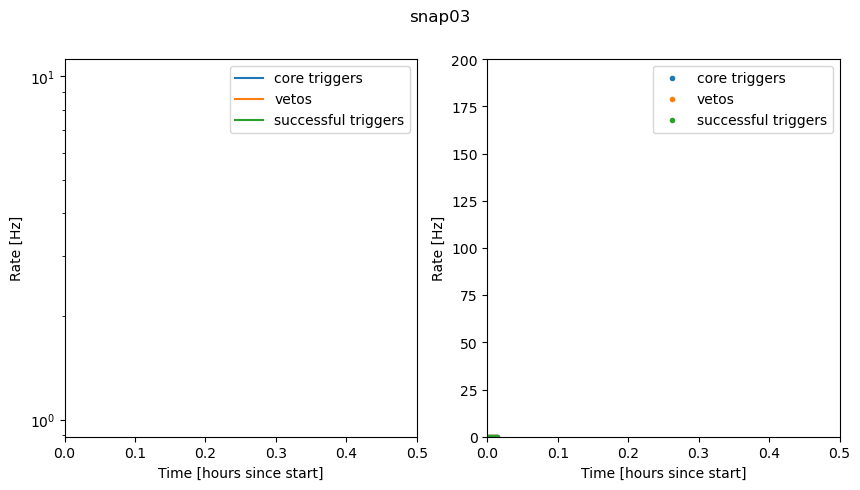

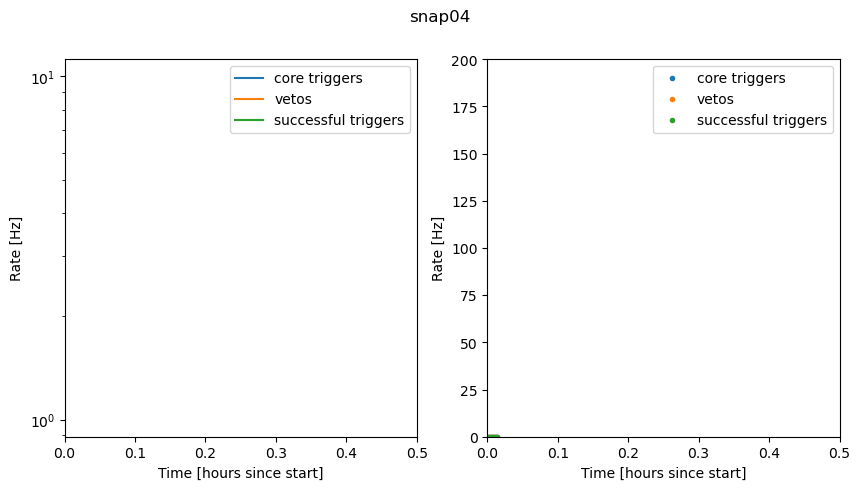

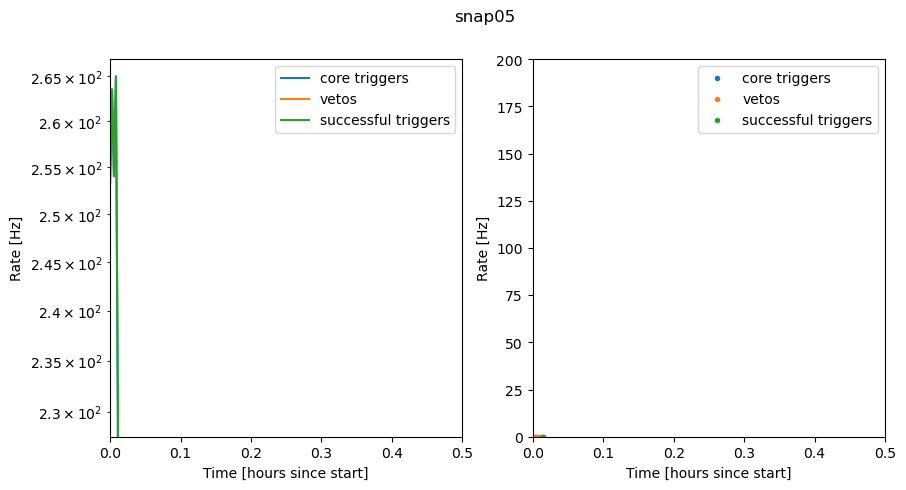

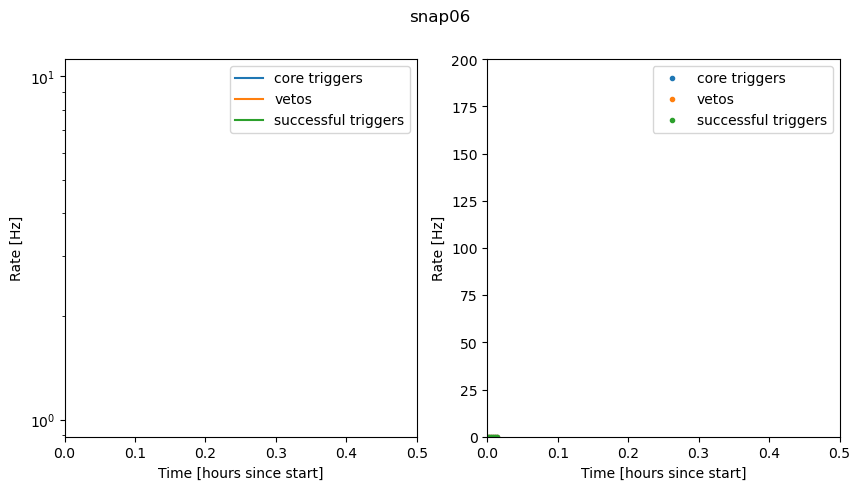

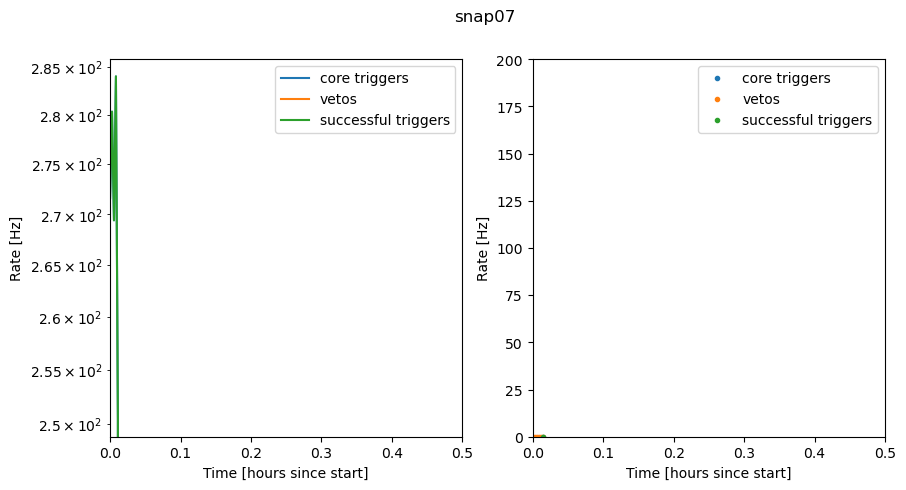

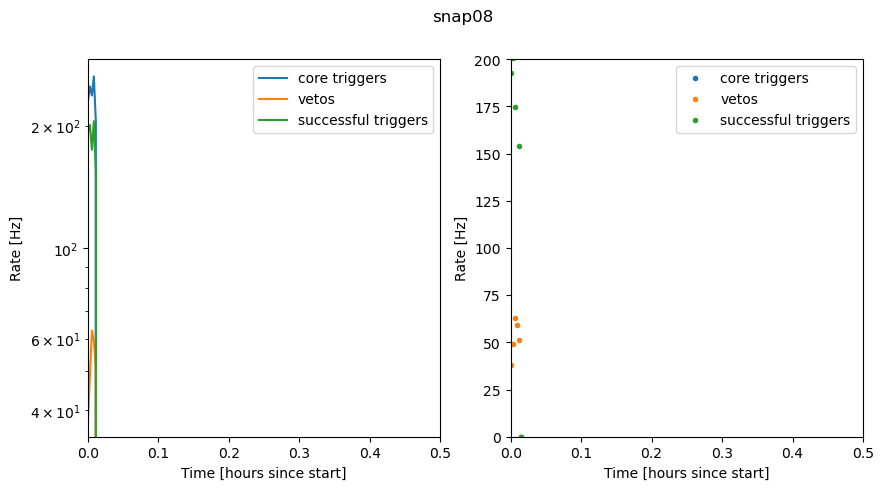

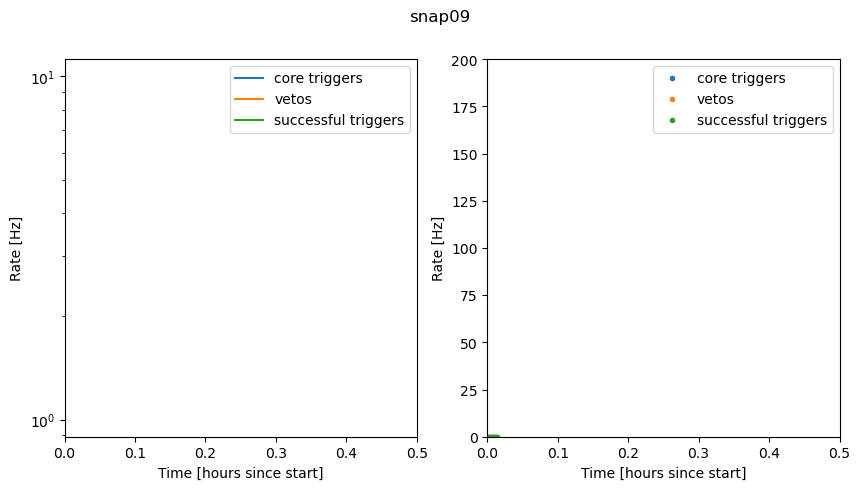

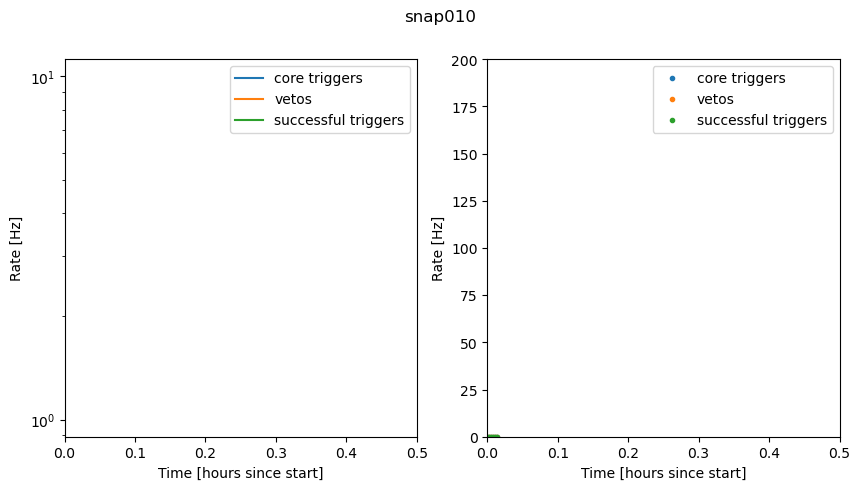

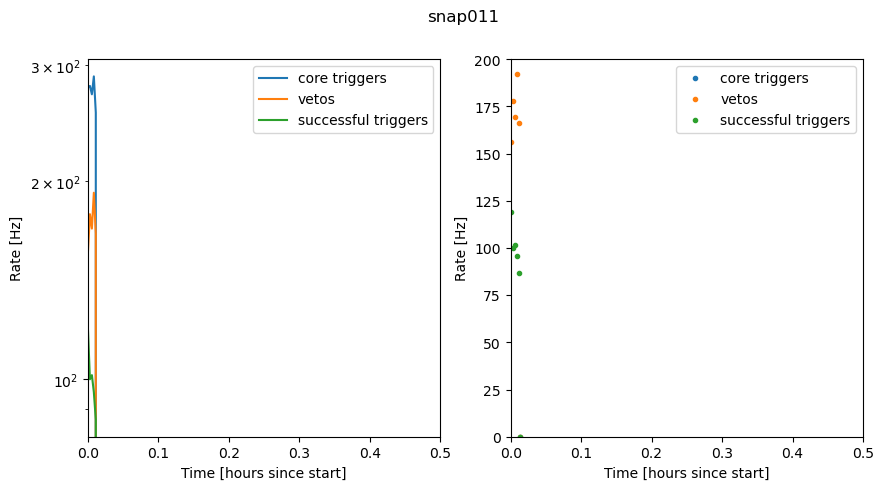

In [72]:

waittime=10

#fname_prefix='/home/ubuntu/kp/data/2023June20/overnight-'
ok_snaps=[2,3,4,5,6,7,8,9,10] #zero indexed

veto_all=(np.load(fname_prefix+'veto'+'.npy'))*0.73 #convert to Hz
core_all=(np.load(fname_prefix+'core'+'.npy'))*0.73 #convert to Hz

veto_cycles=np.load(fname_prefix+'vetocycles'+'.npy')
core_cycles=np.load(fname_prefix+'corecycles'+'.npy')

successful_triggers_all=np.load(fname_prefix+'successfultrigger'+'.npy')*0.73
readout_dones=np.load(fname_prefix+'readoutdone'+'.npy')*0.73


for b in ok_snaps:
    core=core_all[b]
    veto=veto_all[b]
    successful_triggers=successful_triggers_all[b]
    readout_done=readout_dones[b]
    veto_cycle=veto_cycles[b]
    core_cycle=core_cycles[b]
    timeaxis=np.asarray(range(len(core)))*(waittime)*(1/60)*(1/60) #time in hours since start of test, approximated as each board having one measurement every 7*32.75 seconds
    plt.figure(figsize=(10,5),dpi=100)
    plt.suptitle('snap0'+str(b+1))
    
    plt.subplot(121)
    plt.semilogy(timeaxis,core,label='core triggers')
    plt.semilogy(timeaxis,veto,label='vetos')
    plt.semilogy(timeaxis,successful_triggers,label='successful triggers')
    #plt.plot(timeaxis,readout_done,'.',label='readout')

    plt.ylabel("Rate [Hz]")
    plt.xlabel("Time [hours since start]")
    plt.legend()
    plt.xlim(0,0.5)
    
    plt.subplot(122)
    plt.plot(timeaxis,core,'.',label='core triggers')
    plt.plot(timeaxis,veto,'.',label='vetos')
    plt.plot(timeaxis,successful_triggers,'.',label='successful triggers')
    #plt.plot(timeaxis,readout_done,'.',label='readout')
    plt.ylim(0,200)

    plt.ylabel("Rate [Hz]")
    plt.xlabel("Time [hours since start]")
    plt.legend()
    plt.xlim(0,0.5)



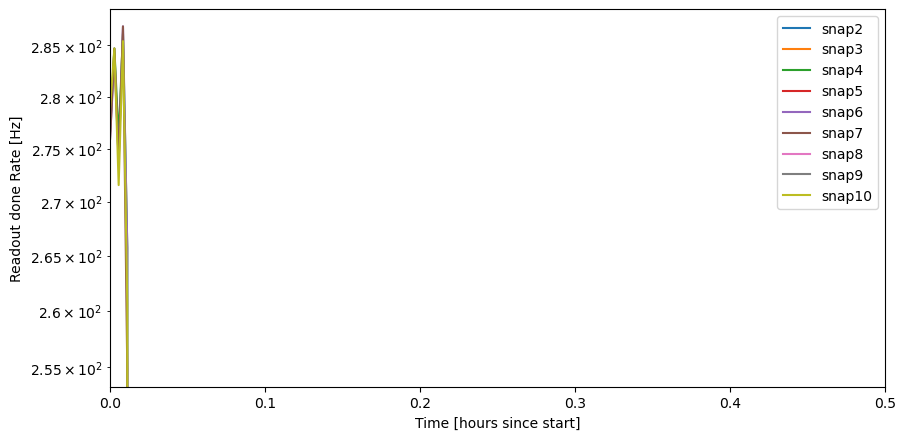

In [73]:
plt.figure(figsize=(10,5),dpi=100)
for b in ok_snaps:
    core=core_all[b]
    veto=veto_all[b]
    successful_triggers=successful_triggers_all[b]
    readout_done=readout_dones[b]
    veto_cycle=veto_cycles[b]
    core_cycle=core_cycles[b]
    timeaxis=np.asarray(range(len(core)))*(waittime)*(1/60)*(1/60) #time in hours since start of test, approximated as each board having one measurement every 7*32.75 seconds
    plt.semilogy(timeaxis,readout_done,label='snap'+str(b))
    plt.ylabel("Readout done Rate [Hz]")
    plt.xlabel("Time [hours since start]")
    plt.legend()
    plt.xlim(0,0.5)
    #plt.ylim(0,200)

/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/ubun

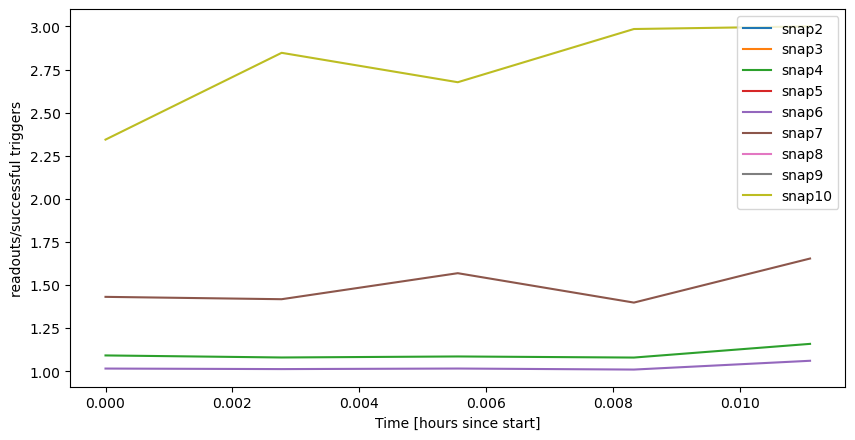

In [75]:
plt.figure(figsize=(10,5),dpi=100)
for b in ok_snaps:
    core=core_all[b]
    veto=veto_all[b]
    successful_triggers=successful_triggers_all[b]
    readout_done=readout_dones[b]
    veto_cycle=veto_cycles[b]
    core_cycle=core_cycles[b]
    timeaxis=np.asarray(range(len(core)))*(waittime)*(1/60)*(1/60) #time in hours since start of test, approximated as each board having one measurement every 7*32.75 seconds
    plt.plot(timeaxis,readout_done/successful_triggers,label='snap'+str(b))
    plt.ylabel("readouts/successful triggers")
    plt.xlabel("Time [hours since start]")
    plt.legend()
    

Plot above shows ratio of readouts to successful triggers for each board.  A readout occurs whenever any board triggers, and so the readout rate can be larger than an individual board's trigger rate.  However, the ratio can also be less than one since triggers continue to be logged while the board is in readout state.

2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0005777825933363883
8 0.0
9 0.0
10 0.001917378984083902


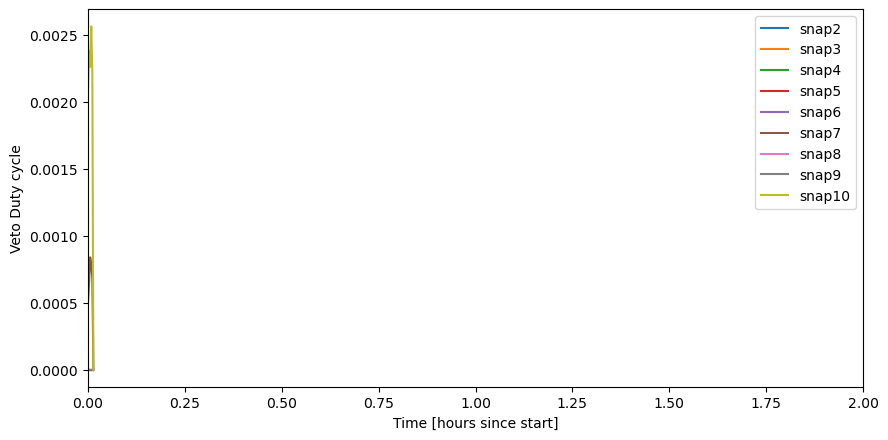

In [76]:
plt.figure(figsize=(10,5),dpi=100)
for b in ok_snaps:
    core=core_all[b]
    veto=veto_all[b]
    successful_triggers=successful_triggers_all[b]
    readout_done=readout_dones[b]
    veto_cycle=veto_cycles[b]
    core_cycle=core_cycles[b]
    timeaxis=np.asarray(range(len(core)))*(waittime)*(1/60)*(1/60) #time in hours since start of test, approximated as each board having one measurement every 7*32.75 seconds
    plt.plot(timeaxis,veto_cycle/((2**28)-1),label='snap'+str(b))
    plt.ylabel("Veto Duty cycle")
    plt.xlabel("Time [hours since start]")
    plt.legend()
    #print('veto cycle')
    print(b,np.mean(veto_cycle)/((2**28)-1))
    #print('core cycle')
    #print(b,np.mean(core_cycle)/((2**28)-1))
    plt.xlim(0,2)

/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0]

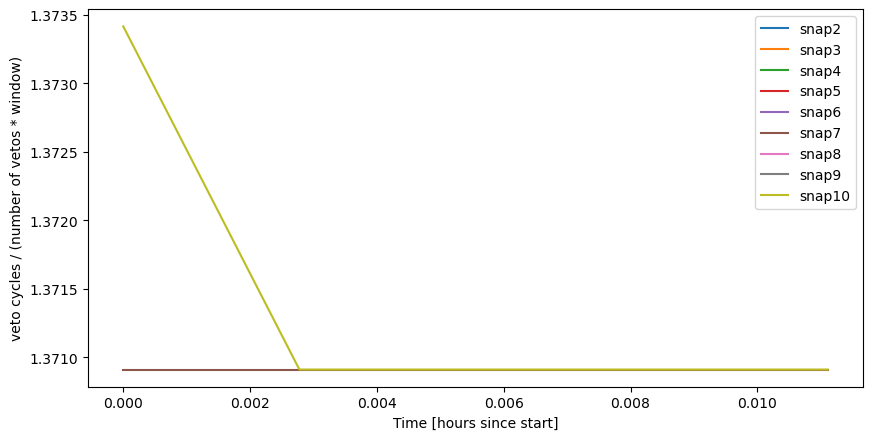

In [77]:
plt.figure(figsize=(10,5),dpi=100)
trigger_window=int(round(1.96e8*100/3e8,1)) #number of clock cycles to travel 100 meters
veto_window=int(round(1.96e8*2000/3e8,1)) #number of clock cycles to travel 2000 meters
for b in ok_snaps:
    core=core_all[b]
    veto=veto_all[b]
    successful_triggers=successful_triggers_all[b]
    readout_done=readout_dones[b]
    veto_cycle=veto_cycles[b]
    core_cycle=core_cycles[b]
    timeaxis=np.asarray(range(len(core)))*(waittime)*(1/60)*(1/60) #time in hours since start of test, approximated as each board having one measurement every 7*32.75 seconds
    plt.plot(timeaxis,(veto_cycle/(2*veto_window*veto)),label='snap'+str(b))
    plt.ylabel("veto cycles / (number of vetos * window)")
    plt.xlabel("Time [hours since start]")
    plt.legend()
    

I think there is a 10% chance the veto window is off by a factor of two.

/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0]

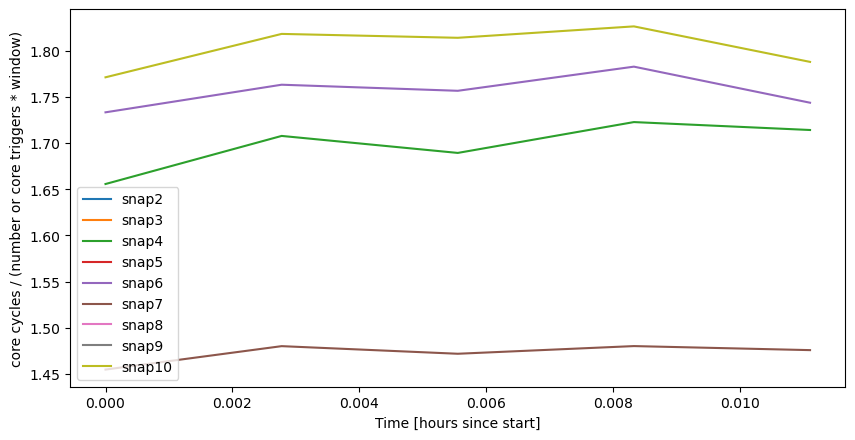

In [78]:
plt.figure(figsize=(10,5),dpi=100)
trigger_window=int(round(1.96e8*100/3e8,1)) #number of clock cycles to travel 100 meters
veto_window=int(round(1.96e8*2000/3e8,1)) #number of clock cycles to travel 2000 meters
for b in ok_snaps:
    core=core_all[b]
    veto=veto_all[b]
    successful_triggers=successful_triggers_all[b]
    readout_done=readout_dones[b]
    veto_cycle=veto_cycles[b]
    core_cycle=core_cycles[b]
    timeaxis=np.asarray(range(len(core)))*(waittime)*(1/60)*(1/60) #time in hours since start of test, approximated as each board having one measurement every 7*32.75 seconds
    plt.plot(timeaxis,(core_cycle/(trigger_window*core)),label='snap'+str(b))
    plt.ylabel("core cycles / (number or core triggers * window)")
    plt.xlabel("Time [hours since start]")
    plt.legend()
    

2024-02-22 19:35:00,889 - lwa_f.blocks.block:snap01 - WARNING - eth - Couldn't find Ethernet core. Will retry later


In [83]:
test.fpga.listdev()

['aaa_onegbe_one_GbE',
 'adc_sync',
 'ads5296_controller0_0',
 'ads5296_controller0_1',
 'ads5296_controller1_0',
 'ads5296_controller1_1',
 'ads5296_hardware_rst0',
 'ads5296_hardware_rst1',
 'ads5296_spi_controller0',
 'ads5296_spi_controller1',
 'ads5296_wb_ram0_0_0',
 'ads5296_wb_ram0_0_1',
 'ads5296_wb_ram0_0_2',
 'ads5296_wb_ram0_0_3',
 'ads5296_wb_ram0_1_0',
 'ads5296_wb_ram0_1_1',
 'ads5296_wb_ram0_1_2',
 'ads5296_wb_ram0_1_3',
 'ads5296_wb_ram1_0_0',
 'ads5296_wb_ram1_0_1',
 'ads5296_wb_ram1_0_2',
 'ads5296_wb_ram1_0_3',
 'ads5296_wb_ram1_1_0',
 'ads5296_wb_ram1_1_1',
 'ads5296_wb_ram1_1_2',
 'ads5296_wb_ram1_1_3',
 'autocorr_acc_cnt',
 'autocorr_acc_len',
 'autocorr_common_dout0_bram',
 'autocorr_common_dout1_bram',
 'autocorr_common_dout2_bram',
 'autocorr_common_dout3_bram',
 'autocorr_common_dout4_bram',
 'autocorr_common_dout5_bram',
 'autocorr_common_dout6_bram',
 'autocorr_common_dout7_bram',
 'autocorr_mux_sel',
 'autocorr_trig',
 'chan_reorder_dynamic_map1',
 'corr_0_

In [101]:
res=getvalue2(test.fpga,"readout_state_value","cr_registers.xlsx")

In [102]:
print(res)

0


In [110]:
res=getvalue(test.fpga,"readout_state_value","cr_registers.xlsx")

In [111]:
def extractvalue2(mainregister,nbits,MSBoffset,bw):
    #extract the value of the specified consecutive bits of mainregister
    #MSBoffset is the offset from the most significant bit of mainregister
    #bw is the bitwidth of the number to extract
    #nbits is the number of bits of mainregister
    #returns the extracted value
    LSBoffset=nbits-(MSBoffset+bw)
    extractmask = ((1<<bw) - 1) <<LSBoffset
    val=(mainregister&extractmask)>> LSBoffset
    return val

def updatevalue2(mainregister,nbits,MSBoffset,bw,newval):
    #update the value of the specified consecutive bits of mainregister
    #MSBoffset is the offset from the most significant bit of mainregister
    #bw is the bitwidth of the number to extract
    #nbits is the number of bits of mainregister
    #newval is the new value to write to that subset of bits
    #returns updated value of mainregister
    LSBoffset=nbits-(MSBoffset+bw)
    extractmask = ((1<<bw) - 1) <<LSBoffset
    excludemask = ((1<<nbits)-1) - extractmask
    mainregister=(mainregister&excludemask) + (newval<<LSBoffset)
    return mainregister

def lookup_register2(name,fname):
    #fname is the file with a table of register information
    #name is the name you want to look up
    registers = pd.read_excel(fname,engine='openpyxl')
    return registers[registers['interface']==name]

def getvalue2(brd,name,fname):
    #brd is a casperfpga CasperFpga object
    #fname is the file name of the register description table
    #name is the name of the quantity you want to read from the board
    info=lookup_register2(name,fname)
    mainregistername=info['registername'].values[0]
    mainregistervalue=brd.read_int(mainregistername)
    value=extractvalue2(mainregistervalue,int(info['mainregister_bitwidth'].values[0]),int(info['offset_from_msb'].values[0]),int(info['bitwidth'].values[0]))
    time.sleep(0.001)
    return value

def setvalue2(brd,name,fname,newvalue):
    #brd is a casperfpga CasperFpga object
    #fname is the file name of the register description table
    #name is the name of the setting you want to update on the board
    #newvalue is the new value you want to update that setting with
    info=lookup_register2(name,fname)
    mainregistername=info['registername'].values[0]
    mainregistervalue=brd.read_int(mainregistername)
    #value=extractvalue(mainregistervalue,info['mainregister_bitwidth'].values[0],info['offset_from_msb'].values[0],info['bitwidth'].values[0])
    updatedvalue=updatevalue2(mainregistervalue,int(info['mainregister_bitwidth'].values[0]),int(info['offset_from_msb'].values[0]),int(info['bitwidth'].values[0]),newvalue)
    brd.write_int(mainregistername,updatedvalue)
    time.sleep(0.001)
    return

In [114]:
setvalue2(snapbrd,"enable_coinc_trig","cr_registers.xlsx",0)


In [4]:
setvalue(snapbrd,"enable_coinc_trig","cr_registers.xlsx",0)


In [8]:

veto_roles_array=np.zeros(64,dtype=int)
core_roles_array=np.zeros(64,dtype=int)
for p in range(11):
    snapbrd=snapbrds[p]
    #setup_coincidencer(snapbrd,0,
    #                      0,
    #                      0,
    #                      0,
    #                      0,
    #                      0,
    #                      core_roles_array,
    #                      veto_roles_array)
    setvalue(snapbrd,"enable_coinc_trig","cr_registers.xlsx",0)

In [7]:
def setup_coincidencer2(casperbrd,trigger_power_thresh,
                      veto_power_thresh,
                      trigger_window,
                      veto_window,
                      antenna_number_thresh,
                      veto_number_thresh,
                      core_roles_array,
                      veto_roles_array):
    # set parameters
    setvalue2(casperbrd,"trigger_power_thresh","cr_registers.xlsx",trigger_power_thresh)
    setvalue2(casperbrd,"veto_power_thresh","cr_registers.xlsx",veto_power_thresh)
    setvalue2(casperbrd,'trigger_window','cr_registers.xlsx',trigger_window) 
    setvalue2(casperbrd,'veto_window','cr_registers.xlsx',veto_window) 
    setvalue2(casperbrd,'antenna_number_thresh','cr_registers.xlsx',antenna_number_thresh) 
    setvalue2(casperbrd,'veto_number_thresh','cr_registers.xlsx',veto_number_thresh) 
    #set the antenna roles
    core_roles1,core_roles2=packantennaroles(core_roles_array)
    veto_roles1,veto_roles2=packantennaroles(veto_roles_array)
    setvalue2(casperbrd,'trigger_antennas1','cr_registers.xlsx',core_roles1)
    setvalue2(casperbrd,'trigger_antennas2','cr_registers.xlsx',core_roles2)
    setvalue2(casperbrd,'veto_antennas1','cr_registers.xlsx',veto_roles1)
    setvalue2(casperbrd,'veto_antennas2','cr_registers.xlsx',veto_roles2)
    return

In [18]:
veto_roles_array=np.zeros(64,dtype=int)
core_roles_array=np.zeros(64,dtype=int)
for p in range(11):
    snapbrd=snapbrds[p]
    #setup_coincidencer(snapbrd,0,
    #                      0,
    #                      0,
    #                      0,
    #                      0,
    #                      0,
    #                      core_roles_array,
    #                      veto_roles_array)
    setvalue(snapbrd,"trigger_power_thresh","cr_registers.xlsx",0)
    setvalue(snapbrd,"veto_power_thresh","cr_registers.xlsx",0)
    setvalue(snapbrd,'trigger_window','cr_registers.xlsx',0) 
    setvalue(snapbrd,'veto_window','cr_registers.xlsx',0) 
    setvalue(snapbrd,'antenna_number_thresh','cr_registers.xlsx',0) 
    setvalue(snapbrd,'veto_number_thresh','cr_registers.xlsx',0) 
    core_roles1,core_roles2=packantennaroles(core_roles_array)
    veto_roles1,veto_roles2=packantennaroles(veto_roles_array)
    setvalue(snapbrd,'trigger_antennas1','cr_registers.xlsx',core_roles1)


Failed to JSON-encode command
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/lwa_f/snap2_feng_etcd_client.py", line 113, in _format_command
    command_json = json.dumps(command_dict)
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/json/__init__.py", line 231, in dumps
    return _default_encoder.encode(obj)
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/json/encoder.py", line 199, in encode
    chunks = self.iterencode(o, _one_shot=True)
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/json/encoder.py", line 257, in iterencode
    return _iterencode(o, 0)
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/json/encoder.py", line 180, in default
    o.__class__.__name__)
TypeError: Object of type 'int64' is not JSON serializable
Failed to JSON-encode command
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/lwa_f/snap2_feng_etcd_client.py", line 113, in

Failed to JSON-encode command
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/lwa_f/snap2_feng_etcd_client.py", line 113, in _format_command
    command_json = json.dumps(command_dict)
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/json/__init__.py", line 231, in dumps
    return _default_encoder.encode(obj)
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/json/encoder.py", line 199, in encode
    chunks = self.iterencode(o, _one_shot=True)
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/json/encoder.py", line 257, in iterencode
    return _iterencode(o, 0)
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/json/encoder.py", line 180, in default
    o.__class__.__name__)
TypeError: Object of type 'int64' is not JSON serializable


TypeError: Object of type 'int64' is not JSON serializable

In [19]:
core_roles1.dtype

dtype('int64')

In [20]:
bin(core_roles1)

'0b0'

In [27]:
a=2**34-1

In [29]:
print(a)
print(int(a))
print(bin(a))
print(len(bin(a)))

17179869183
17179869183
0b1111111111111111111111111111111111
36


In [30]:
def packantennaroles2(roles_array):
    #turn an array of 64 ones and zeros into two 32 bit integers, one for the first half and one for the second
    output1=0
    output2=0
    for i in range(32):
        output1+=roles_array[i]<<(31-i)
        output2+=roles_array[i+32]<<(31-i)
    return output1, output2

In [37]:
o1,o2=packantennaroles2((np.ones(64),dtype=int))

SyntaxError: invalid syntax (<ipython-input-37-afbc5be41ced>, line 1)

In [33]:
o1.dtype

dtype('int64')

In [34]:
len(bin(o1))

3

In [40]:
core_roles_array=np.ones(64,dtype=int)
o1,o2=packantennaroles2(core_roles_array)

In [41]:
o1.dtype

dtype('int64')

In [45]:
print(len(bin(o1)))
print(len(bin(int(o1))))
print(bin(int(o1)))
print(bin(o1))

34
34
0b11111111111111111111111111111111
0b11111111111111111111111111111111


In [11]:
snapbrd.read("cosmic_ray_core_n_veto_tot_clk_cycles",2*4,0)

Command status from FID 3 returned: 'error'
Command status from FID 3 returned: 'error'
Command status from FID 3 returned: 'error'
Command status from FID 3 returned: 'error'
Command status from FID 3 returned: 'error'
Command status from FID 3 returned: 'error'
Command status from FID 3 returned: 'error'
Command status from FID 3 returned: 'error'
Command status from FID 3 returned: 'error'
Command status from FID 3 returned: 'error'
Command status from FID 3 returned: 'error'


{}

In [10]:
snapbrd.listdev()


['aaa_onegbe_one_GbE',
 'adc_sync',
 'ads5296_controller0_0',
 'ads5296_controller0_1',
 'ads5296_controller1_0',
 'ads5296_controller1_1',
 'ads5296_hardware_rst0',
 'ads5296_hardware_rst1',
 'ads5296_spi_controller0',
 'ads5296_spi_controller1',
 'ads5296_wb_ram0_0_0',
 'ads5296_wb_ram0_0_1',
 'ads5296_wb_ram0_0_2',
 'ads5296_wb_ram0_0_3',
 'ads5296_wb_ram0_1_0',
 'ads5296_wb_ram0_1_1',
 'ads5296_wb_ram0_1_2',
 'ads5296_wb_ram0_1_3',
 'ads5296_wb_ram1_0_0',
 'ads5296_wb_ram1_0_1',
 'ads5296_wb_ram1_0_2',
 'ads5296_wb_ram1_0_3',
 'ads5296_wb_ram1_1_0',
 'ads5296_wb_ram1_1_1',
 'ads5296_wb_ram1_1_2',
 'ads5296_wb_ram1_1_3',
 'autocorr_acc_cnt',
 'autocorr_acc_len',
 'autocorr_common_dout0_bram',
 'autocorr_common_dout1_bram',
 'autocorr_common_dout2_bram',
 'autocorr_common_dout3_bram',
 'autocorr_common_dout4_bram',
 'autocorr_common_dout5_bram',
 'autocorr_common_dout6_bram',
 'autocorr_common_dout7_bram',
 'autocorr_mux_sel',
 'autocorr_trig',
 'chan_reorder_dynamic_map1',
 'corr_0_

In [13]:
snapbrd.read_list_from_ram("cosmic_ray_thresh_rate1", 32, 'u4') 

AttributeError: 'Fpga' object has no attribute 'read_list_from_ram'